# Notebook master

As the notebook for this project has gotten unweildenly large and it has all sorts of scattered analyses I'm trying to clean things up by having a master notebook that loads the data, but the plotting and data dives happen in other notebooks.

# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools, os, glob
from matplotlib_venn import venn2
from copy import copy
import warnings
warnings.simplefilter('ignore')
sb.set_context("notebook")
sb.set_style('ticks')

import matplotlib as mpl
def figres(dpi):
    mpl.rc("savefig", dpi=dpi)
figres(100)
from IPython.core.pylabtools import figsize

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import PchipInterpolator
from scipy import stats
from scipy.spatial.distance import pdist
from scipy.spatial import distance
import statistics 
cmapSpecial = mpl.colors.LinearSegmentedColormap.from_list("", ['blue','white',"red"])

from tqdm import tqdm_notebook as tq

import import_ipynb
#Includes functions to get 
import GetGenesFormPathCards as PCG

importing Jupyter notebook from GetGenesFormPathCards.ipynb


In [2]:
runCode=False

## Genes

In [3]:
""" 
gene_list.txt has format:
                          ID=g1;Name=g1;Note=g1|introns:0|%transcript_support:0
                          ID=g2408;Name=Eci1;Note=Enoyl-CoA delta isomerase 1, mitochondrial  [Mus musculus]
"""
def getGeneNames(file='gene_list.txt',sep=';',sep2='=',extraBS=True):
    gene_names = defaultdict(str)
    with open(file) as f:
        for line in f:
            parts = line.split(sep)
            g = parts[0].split(sep2)[1].strip()
            n = parts[1].split(sep2)[1].strip()
            d = parts[2].split(sep2)[1].strip()
            if g not in d:
                n += " "+d
            gene_names[g] = n
    if(extraBS):
        gene_names["mFuHC"] = "mFuHC"
        gene_names["sFuHC"] = "sFuHC"
    return gene_names

def getLogCPM(counts):
    cpm = (1e6*counts / counts.sum())
    logCPM = np.log2(cpm + 1)
    return logCPM

In [4]:
# Left over from Mark, we didn't use it, but maybe it will mean somthing to you
def homology(S, same=False):
    """ Returns list of gene names or geneIDs in list S that have known homology """
    named = []
    for s in S:
        n = gene_names[s.split(".")[0]]
        if "[Homo" in n or "[Mus" in n or "BHF" in n or "FuHC" in n:
            if same:
                named.append(s)
            else:
                named.append(n)
    return named

## Sample metadata

In [5]:
gene_names = getGeneNames()
# counts is just counts of each gene for each sample
counts = pd.read_table("gene_counts.txt", sep="\t", index_col=0)
logCPM = getLogCPM(counts)

# free_run tells the age and time of samples
free_run = pd.read_csv('all_clock_free_run.csv',index_col=0)
free_run.index.name=""
# remove samples with less than 5000 total counts
bad_samples = free_run.index[((counts.loc[:, free_run.index] > 0).sum() < 5000)]
free_run.drop(bad_samples, inplace=True)
e_color_dict = {t:c for t,c in zip(free_run["Time"].unique(), sb.color_palette("inferno", n_colors=15))}

# Seperated into different ages, as ages arn't compared to one another
young = free_run[free_run['Days old']<200]
youngCounts = counts[young.index]
mid = free_run[free_run['Days old'].between(200, 3000, inclusive=True)]
midCounts = counts[mid.index]
old = free_run[free_run['Days old'] > 3000]
oldCounts = counts[old.index]

# Include an different groups you want to run in runLst
# include the name of the group, the age/time info dataframe of the group, and the counts dataframe of the group
runLst=[('young',young,youngCounts),('mid',mid,midCounts),('old',old,oldCounts)]

## Differential expression

### R functions

In [6]:
def write_count_subset(s1, s2, filename):
    """ Writes the samples contained in s1 and s2 to file f """
    counts.loc[:, s1 + s2].to_csv(filename, sep="\t")

def edgeR(filename, n, m, pvalue=0.05):
    """ R function that runs edgeR and produces plots and DE gene list """
    %load_ext rpy2.ipython
    %R library("edgeR")
    %R rm(list=ls())
    %Rpush filename n m pvalue
    %R x <- read.delim(filename, row.names=1)
    %R y <- DGEList(counts=x, group=c(rep("pos",n), rep("neg",m)), genes=rownames(x))
    %R keep <- rowSums(cpm(y)>5) >= 2
    %R y <- y[keep,]
    %R y$samples$lib.size <- colSums(y$counts)
    %R l <- read.delim("gene_lengths.txt", row.names=1, header=FALSE)
    %R y$genes$length <- l[y$genes$genes, ]
    %R y <- calcNormFactors(y)
    %R y <- estimateCommonDisp(y)
    %R y <- estimateTrendedDisp(y)
    %R y <- estimateTagwiseDisp(y)
    %R et <- exactTest(y)
    %R summary(de <- decideTestsDGE(et, p.value=pvalue))
    import os
    prefix = os.path.dirname(filename)+"/"+filename.split("/")[-1].split(".")[0]
    %R n_de <- sum(abs(de))
    %Rpull n_de
    if n_de[0]:
        %Rpush prefix
        %R write.table(topTags(et, n=n_de)$table, file=paste(prefix, ".de.txt", sep=""), sep="\t", row.names=FALSE, quote=FALSE)
    else:
        prefix=None
    return prefix

def run_edgeR(s1, s2, filename, pvalue=0.05):
    """ Master function to call everything, returns two lists of genes """
    write_count_subset(s1, s2, filename)
    n, m = len(s1), len(s2)
    f = edgeR(filename, n, m, pvalue=pvalue)

### Time series

Assume we have five samples ordered by pseudotime (A-E), then we want to find all of the following types of sets:
* A-B, A-C, A-D, A-E
* A-BC, A-CD, A-DE
* A-BCD, A-CDE
* A-BCDE
* $\vdots$
* ABCD-E

To do this, the function below takes an iterable and loops over the following four values, $i$, $m$, $j$ and $m$.
* $i$ - starting index, constrained to be between [0, N] where N is the length of the iterable
* $n$ - size of the first group, sized between [1, N-i-1]
* $j$ - start of the second group index
* $m$ - length of the last group, sized between [1, N-j]

In [7]:
def generate_timeseries_permutations(L):
    """ Generator for time series permutations """
    N = len(L)
    for i in range(N):
        for n in range(1, N-i):
            for j in range(i+n, N):
                for m in range(1, N-j+1):
                    yield(list(L[i:i+n]), list(L[j:j+m]))

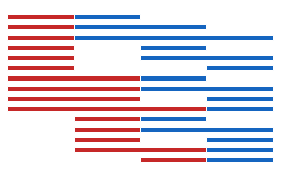

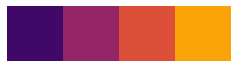

In [8]:
# Visual of time series permutations
# In edgeR/DESeq it would be comparison of red vs blue
#                running through all possible combinations
red = "#C62828"
blue = "#1565C0"
figsize(5, 3)
for i,j in enumerate(reversed(list(generate_timeseries_permutations(range(4))))):
    a,b = j
    plt.barh(y=i, width=max(a)-min(a)+1, left=min(a), color=red, height=0.5)
    plt.barh(y=i, width=max(b)-min(b)+1, left=min(b), color=blue, height=0.5)

plt.axis("off")
plt.show()

sb.palplot(sb.color_palette("inferno", n_colors=4))
plt.axis("off")
plt.show()

In [9]:
def setUpDESeq(runLst,runEdgeR=False):
    """Sets up files so they can be properly run in DESeq/edgeR
    Mark managed to run R code in the notebook, where as I did not
    If you can just run the R code set runEdgeR to be True,
    else after running this everything will be setup to run the acompanying DESeq R notebook
    Warning: Creates many new directories when run"""
    for freeRun in tq(runLst,desc='SetupDESeq'):
        name = freeRun[0]
        df = freeRun[1]
        counts = freeRun[2]
        for a,b in tq(generate_timeseries_permutations(df["Time"].unique()),desc='Permutations for '+name):
            s1 = list(df.index[df["Time"].isin(a)])
            s2 = list(df.index[df["Time"].isin(b)])
            nameLst=[]
            heatLst=[]
            for i in s1:
                nameLst.append(i)
                heatLst.append('Hot')
            for i in s2:
                nameLst.append(i)
                heatLst.append('Cold')
            out = pd.DataFrame(heatLst,nameLst,columns=['Group'])
            a = list( map(str, a))
            b = list( map(str, b))
            filename = "_".join(a) + "-" + "_".join(b)
            filename = name+"/edgeR/0.05/" + filename
            if not os.path.exists(name):
                os.mkdir(name)
            if not os.path.exists(name+"/edgeR/"):
                os.mkdir(name+"/edgeR/")
            if not os.path.exists(name+"/edgeR/0.05"):
                os.mkdir(name+"/edgeR/0.05")
            out.to_csv(filename+'colData.csv')
            countsOut = counts.loc[:, s1 + s2]
            countsOut.to_csv(filename+'counts.csv')
            if(runEdgeR):
                if not os.path.exists(filename + ".de.txt"):
                    run_edgeR(s1, s2, filename, pvalue=0.05)
                    ! rm {filename}
                    ! touch {filename}.de.txt
    return 1

Another pattern to look for is multiple repeated humps, as in the blastogenensis cycle, the stages are all repeated multiple times as the secondary bud makes its way to becoming a zooid. The above method can be generalized to allow for 2-3 humps quite simply.

Do this by splitting the blastogenesis times into partitions, and then using the existing function for each 'up-down' comparison, joining them together for the partitions.

In [10]:
# Leftover Mark stuff
def generate_all_partitions(L, n=2):
    """ Generates all n partitions possible of length N """
    N = len(L)
    ranges = itertools.repeat(range(N), n)
    for X in itertools.product(*ranges):
        if sum(X) == N and all(x >= 2 for x in X):
            partitions = []
            for i in range(n):
                start = sum(X[:i])
                partitions.append(L[start:start+X[i]])
            yield partitions

def generate_partition_times(L, n=2):
    for partition in generate_all_partitions(L, n):
        gtps = [list(generate_timeseries_permutations(p)) for p in partition]
        #print(gtps)
        for g in itertools.product(*gtps):
            up, down = [], []
            for h in g:
                up.append(h[0])
                down.append(h[1])
            yield list(itertools.chain.from_iterable(up)), list(itertools.chain.from_iterable(down))
            
def hump_blastogenesis_edgeR(X):
    a,b = X
    s1 = list(blastogenesis.index[blastogenesis["Time"].isin(a)])
    s2 = list(blastogenesis.index[blastogenesis["Time"].isin(b)])
    filename = "_".join(a) + "-" + "_".join(b)
    filename = "blastogenesis/edgeR_hump/0.05/" + filename
    if not os.path.exists(filename + ".de.txt"):
        print("*", end="")
        run_edgeR(s1, s2, filename, pvalue=0.05)
        ! rm {filename}
        ! touch {filename}.de.txt

In [11]:
# Running Code
if(runCode):
    setUpDESeq(runLst,runEdgeR=False)

# If runEdgeR==False, Must now run DESeq R notebook to be able to move on

### Time signatures
Now that I have all of the DE tests performed, I go through all the files and see which patterns are compatible for each gene, and then score to select the best pattern for each pattern.

In [12]:
debug=False
import pdb

def get_differential_genes(files):
    """ Returns a dictionary of DE genes in each comparison """
    stages = {}
    for f in files:
        if os.stat(f).st_size:
            a, b = f.split("\\")[-1].split(".")[0].split("-")
            df = pd.read_csv(f, index_col=0)
            df = df[df['pvalue']<=0.05]
            u, d = tuple(a.split("_")), tuple(b.split("_"))
            stages[u, d] = set(df[df["log2FoldChange"] > 0].index), set(df[df["log2FoldChange"] < 0].index)
    return stages

def invert_differential_genes(stages):
    """ Returns an inverted dictionary, of the stages compatible with each gene """
    genes = defaultdict(list)
    for a,b in stages:
        u, d = stages[a, b]
        for g in u:
            genes[g].append((a, b))
        for g in d:
            genes[g].append((b, a))
    return genes

def generate_patterns(patterns, times):
    """ Generator of patterns """
    for p in patterns:
        u = p[0]
        d = pd.Index(times).drop(u)
        yield list(u), list(d)
        
def remove_redundant_patterns(patterns):
    """ Returns patterns without redundancies """
    nr_patterns = []
    for p in patterns:
        if p not in nr_patterns:
            nr_patterns.append(p)
    return nr_patterns

def tupleToint(tup):
    out = ()
    for i in range(len(tup)):
        elem  = tup[i]
        elem = int(elem)
        out += (elem,)
    return out

def score_pattern(observed, pattern):
    """ Returns the proportion of times that the observed expression follows the desired pattern """
    x1, x2 = observed # these are both tuples of +ve/-ve
    x1 = tupleToint(x1)
    x2 = tupleToint(x2)
    y1, y2 = pattern
    agree = len(set(x1) & set(y1)) + len(set(x2) & set(y2))
    disagree = len(set(x1) & set(y2)) + len(set(x2) & set(y1))
    if(debug):
        pdb.set_trace()
    return agree - disagree

def gene_pattern(observations, pattern):
    """ Mapped form of above """
    return sum([score_pattern(o, pattern) for o in observations])

def gene_patterns(observations, patterns):
    """ Like above, but with multiple patterns """
    scores = {i:gene_pattern(observations, p) for i,p in enumerate(patterns)}
    return scores

def parallel_gene_patterns(g, genes,patterns, directory="development/blastogenesis/scores"):
    """ Version of above for parallelizing """
    import pandas as pd
    import os
    if not os.path.exists(directory):
        os.mkdir(directory)
    f = "{}/{}.txt".format(directory, g)
    S = pd.Series(gene_patterns(genes[g], patterns))
    S.to_csv("{}/{}.txt".format(directory, g), sep="\t")
    return 1
def idxMax(series): 
    test2  = series.to_frame()
    curMax=0
    idMax = 0
    for num in range(len(test2.index)):
        i = test2.index[num]
        row = test2.loc[i].values[0]
        if(row > curMax):
            curMax = row
            idMax = num
    return idMax
debug=False
def best_gene(scores, g):
    """ Returns the top pattern for a gene, and whether it is up or down """
    if(debug):
        import pdb;pdb.set_trace()
    top = idxMax(scores.loc[g].abs())
    if top is None or g is None:
        import pdb; pdb.set_trace()
    try:    
        if scores.loc[g][top] > 0:
            return top, True
        else:
            return top, False
    except ValueError as e:
        print('Error, check me out!!!')
        import pdb
        pdb.set_trace()
        raise e
def get_best_genes(scores):
    """ Returns dictionaries of the genes that best fit given patterns """
    Up = defaultdict(list)
    Down = defaultdict(list)
    for g in scores.index:
        top, pos = best_gene(scores, g)
        if pos:
            Up[top].append(g)
        else:
            Down[top].append(g)
    return Up, Down

In [13]:
def postDESeq(runLst,skipToTry=False,save=True):
    """After edgeR/DESeq is run, this creates the gene scores files and then the binary score file
    
    param: runLst, same runLst used to run edgeR/DESeq
    param: skipToTry, boolen telling if to skip past creating gene score files, assumes they are already saved
    param: save, boolean telling if to save gene scores and final binary table 
    """
    for run in tq(runLst,desc='Overall'):
        ageName = run[0]
        ageTimes = run[1]
        ageCounts = run[2]
        if not(skipToTry):
            run_genes = invert_differential_genes(get_differential_genes(tq(glob.glob(ageName+"/edgeR/0.05/*.de.txt"),
                                                                            desc='Comparisons for '+ageName)))
            run_patterns = remove_redundant_patterns(generate_patterns(generate_timeseries_permutations(ageTimes["Time"].unique()),
                                                                ageTimes["Time"].unique()))
            for gene in tq(run_genes,desc='Calculating Scores for '+ageName):
                parallel_gene_patterns(gene,run_genes,run_patterns,directory=ageName+'/scores')
    
        try:
            run_scores = pd.read_table(ageName+"/"+ageName+"_scores.txt", index_col=0)
        except:
            print('run_scores not found, will create')
            run_scores = pd.DataFrame(index=run_genes.keys(), columns=np.arange(len(run_patterns)))
            for f in tq((glob.glob(ageName+"/scores/*")),desc='Super Score for '+ageName):
                g = f.split('\\')[-1].split('.txt')[0]
                df = pd.read_table(f, index_col=0, names=[g])
                run_scores.loc[g] = df[g]
            if(save):
                run_scores.to_csv(ageName+"/"+ageName+"_scores.txt", sep="\t")
        run_scores.dropna(inplace=True)
        runUp, runDown = get_best_genes(run_scores)
        
        finalOut = pd.DataFrame(index=logCPM.index, columns=ageTimes["Time"].unique()).fillna(0)
        for i,k in enumerate(run_patterns):
            g = runUp[i]
            for t in k[0]:
                finalOut.loc[g, t] = 1
            g = runDown[i]
            if('Days old' in g):
                g.remove('Days old')
            if('Time' in g):
                g.remove('Time')
            for t in k[1]:
                finalOut.loc[g, t] = 1
    
        sortCols = list(finalOut.columns.sort_values())
        finalOut = finalOut[sortCols]
        finalOut["gene"] = [gene_names[g.split(".")[0]].split(" ")[0] for g in finalOut.index]
        if(save):
            finalOut.to_csv(ageName+"/"+ageName+"_binary.txt", sep="\t")
    return finalOut

In [14]:
# Running Code
if(runCode):
    postDESeq(runLst,save=False)

# Enrichment

In [15]:
def goodSamples(lst1,lst2):
    out=[]
    for elem in lst1:
        if(elem in lst2):
            out.append(elem)
    return out
def binaryGeneDict(binary,col,genes,GI='gi'):
    """Creates dictionary relating gene names to corresponding GI numbers
        param: binary, binary table to be used to relate gene names to GIs
        param: col, column of binary table that contains the gene names
        param: genes, list of gene names to be included in the dictionary"""
    outDict={}
    binary[GI] = binary.index
    binary.index = binary[col]
    genes = goodSamples(genes,binary.index)
    binary2 = binary.loc[genes]
    binary2.index = binary2[GI]
    binary2.index.name=''
    binary2.drop(columns=GI,inplace=True)
    for gene in binary2.index:
        genename = binary2.loc[gene][col]
        if (genename in outDict):
            outDict[genename].append(gene)
            outDict[genename] = [gene]
        else:
            outDict[genename] = [gene]
    binary.index = binary[GI]
    binary.index.name=''
    binary.drop(columns=GI,inplace=True)
    return outDict

debug=False

def noNegs(lstIn,inplace=True,top=True):
    """Removes negative values from the list, replacing them with 0's"""
    if(inplace):
        lst = lstIn
    else:
        lst = lstIn.copy()
    for num in range(len(lst)):
        i = lst[num]
        if(i < 0):
            lst[num] = 0
        if(i>=1 and top):
            lst[num] = 1
    return lst

def plot_enrichment(genes, binary, color='blue', label="", title="",
                    named=False,percts=[0.5,0.99], ax=None,plotBase=False,GI='gi'):
    """
    plots the enrichment of the given list of genes over the time
    param: genes, a list of genes to be considered as a single pathway for enrichment plotting
    param: binary, the binary table to be used to compute the enrichment of the given list/pathway
    param: color, the color of the plotted line/highlighted area 
                 (the higlighted area's color will be transperant for each value in percts)
    param: label, label name that will appear in legend (best used if multiple ages are in one plot)
        default = ""
    param: title, title that will appear at top of the plot
        default = ""
    param: named, boolean telling if genes is a list of gene names (True) or GI numbers (False)
        default = flase
    param: percets: list of percentiles to highlight around poltted line
        defualt = [0.5,0.99] for the 50th and 99th percentiles
    """
    if(named):
        genes = goodSamples(genes,binary['gene'].values)
        binaryDict = binaryGeneDict(binary,'gene',genes,GI)
        geneLst=[]
        for g in genes:
            g1 = binaryDict[g]
            geneLst += g1
        genes = geneLst
    binary = binary.drop(columns='gene')
    genes = goodSamples(genes,binary.index)
    ax = plt.gca()
    y = binary.loc[genes].sum()/len(genes)
    M = binary.shape[0]
    N = len(genes)
    # subtracts the [](https://en.wikipedia.org/wiki/Hypergeometric_distribution)
    base = binary.sum().apply(lambda x: stats.hypergeom.mean(M, int(x), N)/N)
    y2 = y-base
    noNegs(y2)
    noNegs(y)
    noNegs(base)
    x = np.arange(len(y))
    if(debug):
        import pdb;pdb.set_trace()
    T = np.linspace(0, max(x), 100)
    ax.plot(T, 100*PchipInterpolator(x, y.astype('float'))(T), linewidth=2, color=color, label=label)
    #old method
    #ax.plot(T, 100*PchipInterpolator(x, y2.astype('float'))(T), linewidth=2, color=color, label=label)
    if(plotBase):
        ax.plot(T, 100*PchipInterpolator(x, base.astype('float'))(T),'--', linewidth=2, color=color, label=label+' Base Line')
    for p in percts:
        lower = y2+binary.sum().apply(lambda x: stats.hypergeom.interval(p, M, int(x), N)[0]/N)
        noNegs(lower)
        upper = y2+binary.sum().apply(lambda x: stats.hypergeom.interval(p, M, int(x), N)[1]/N)
        noNegs(upper)
        #old method
        #lower = y-binary.sum().apply(lambda x: stats.hypergeom.interval(p, M, int(x), N)[0]/N)
        #noNegs(lower)
        #upper = y-binary.sum().apply(lambda x: stats.hypergeom.interval(p, M, int(x), N)[1]/N)
        #noNegs(upper)
        ax.fill_between(T, 100*PchipInterpolator(x, lower.astype('float'))(T), 
                            100*PchipInterpolator(x, upper.astype('float'))(T), alpha=0.3, color=color)
    ax.spines['bottom'].set_position('zero')
    ax.set_xticks(x)
    #ax.set_ylim(0,100)
    ax.set_xticklabels(y.index, rotation=90)
    ax.set_ylabel("% enrichment")
    ax.set_title(title)
    sb.despine()
    return (title)

In [16]:
def plotAges(genes,ageLst,percets=[0.68,0.95],title='',named=True,save=False,plotBase=True,GI='gi'):
    """
    plots the different groups (ages) enrichments on a single graph 
    
    param: genes, list of genes to be considered as a pathway on which to run enrichment
    param: ageLst, list of tuples with the name of the age/group and the color it should be plotted with
           ex: [('young','blue'),('old','red')]
    param: percets, list of percentiles to highlight around poltted line
        defualt = [0.68,0.99] for the 68th and 95th percentiles (roughly 1 and 2 std)
    param: title, title of the overall plot
        default = ''
    param: named, boolean telling if genes is a list of gene names (True) or GI numbers (False)
        default = True
    """
    for age in ageLst:
        name = age[0]
        color = age[1]
        binary = pd.read_csv(name+'/'+name+'_binary.txt',sep='\t',index_col=0)
        out = plot_enrichment(genes,binary,color=color,label=name,named=named,
                              percts=percets,title=title,plotBase=plotBase,GI=GI)
    plt.legend(loc=(1,0.5))
    if(save):
        if not os.path.exists('Save'):
            os.mkdir('Save')
        if(plotBase):
            title += 'with base line'
        plt.savefig('Save/'+title+'.png',bbox_inches='tight')
    plt.show()

Code assumes that all gene lists for plotting are in the directory 'Gene Lists', each list seperated by spaces/tabs/newlines, if seperated by somthing else (commas, etc.) include that in sep (for example if seperator is commas, sep=',').

A useful function to get pathway gene lists is<br>
### PCG.getPathCards()<br> 
Which given a list of [PathCards](https://pathcards.genecards.org/) pathway names will get that pathways genes and save them in the provided directory (default is 'Gene Lists/Named/')

In [17]:
lst = ['Mitochondrial Fatty Acid Beta-Oxidation','Protein Processing in Endoplasmic Reticulum']
out = PCG.getPathCards(lst,direct='Gene Lists/Extra/')

In [17]:
ageLstColors = [('Young',sb.color_palette("Set1")[2]),('Mid',sb.color_palette("Set1")[3]),('Old',sb.color_palette("Set1")[4])]
#                          'green'                             'orange'                            'purple'

def plotGeneLists(sep='',percents=[0.68],directory='Gene Lists/',named=False,
                  ageLst=ageLstColors,save=False,plotBase=True,GI='gi'):
    """plots the enrichment plots for all the pathway lists stored in Named and GI folders
        param: sep, seperator for the inputed lists
            default = ''
        param: percents, list of percentiles for highlighted plot area around the line
            default = [0.68] (about 1 std from the mean)
        param: directory, the directory where 'Named' and 'GI' and the gene lists are held
            default = 'Gene Lists/'
        param: ageLst, list of tuples with the name of the age/group and the color it should be plotted with
               ex: [('young','blue'),('old','red')]
            default = ageLstColors (see above)
        param: save, boolean telling if to save the plots that are created (will be save in a folder named 'Saved/')
        """
    fileLst = glob.glob(directory+'*')
    for file in tq(fileLst,desc='Plotting Enrichment'):
        genes = PCG.readLst(file,sep)
        file1 = file.split('\\')[-1]
        file1 = file1.replace('.txt','')
        file1 = file1.replace('_',' ')
        file1 = file1.title()
        # Uses the name of the pathway list file as the title for the plot
        plotAges(genes,title=file1,named=named,ageLst=ageLst,percets=percents,save=save,plotBase=plotBase,GI=GI)
    return 1

# Find other genes with similar/oppisite binary expression patterns

In [18]:
def renameTime(age):
    timeRename ={}
    timeRename['0'] = age+'_0'
    timeRename['3'] = age+'_3'
    timeRename['6'] = age+'_6'
    timeRename['9'] = age+'_9'
    timeRename['12'] = age+'_12'
    timeRename['15'] = age+'_15'
    timeRename['18'] = age+'_18'
    timeRename['21'] = age+'_21'
    timeRename['gene'] = age+'_gene'
    return timeRename

In [19]:
def getBinaryAll():
    age = 'old'
    binaryOld = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
    age = 'mid'
    binaryMid = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
    age='young'
    binaryYoung = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
    binaryAll = binaryYoung.rename(columns=
                                   renameTime('young')).merge(binaryMid.rename(columns
                                                                               =renameTime('mid')),
                                                              left_index=True, right_index=True).merge(binaryOld.rename(columns=
                                                                                                                        renameTime('old')),
                                                                                                       left_index=True,
                                                                                                       right_index=True).drop(columns=
                                                                                                                              ['young_gene',
                                                                                                                               'mid_gene']).rename(columns=
                                                                                                                                                   {'old_gene':'gene name'})
    return binaryAll

In [20]:
def similarOppisteGenes(gene,similar=True):
    binaryAll = getBinaryAll()
    skipLst=[gene]
    pattern = binaryAll.loc[gene].drop('gene name')
    outG=[]
    if(similar):
        outDiff =100
    else:
        outDiff = -100
    for g in (binaryAll.index):
        if not(g in skipLst):
            pattern2 = binaryAll.loc[g].drop('gene name')
            difference = abs(pattern - pattern2).sum()
            if(similar):
                if(difference == outDiff):
                    outG.append(g)
                else:
                    if(difference < outDiff):
                        outG = [g]
                        outDiff = difference
            else:
                if(difference == outDiff):
                    outG.append(g)
                else:
                    if(difference > outDiff):
                        outG = [g]
                        outDiff = difference
    return outG,outDiff

In [21]:
def getGIs(gene):
    binaryAll = getBinaryAll()
    gene=gene.upper()
    lst = list(binaryAll[binaryAll['gene name']==gene].index)
    gene=gene.lower()
    gene = gene.capitalize()
    lst2 = list(binaryAll[binaryAll['gene name']==gene].index)
    for elem in lst2:
        if not elem in lst:
            lst.append(elem)
    print('Found '+str(len(lst))+' GIs associated with that gene name:')
    print(', '.join(lst))
    return lst

In [22]:
def saveLstTup(lst,file):
    with open(file,'w') as f:
        for num in range(len(lst)-1):
            elem = lst[num]
            for eNum in range(len(elem)-1):
                e = elem[eNum]
                f.write(str(e)+'\t')
            e = elem[len(elem)-1]
            f.write(str(e)+'\n')
        elem =lst[len(lst)-1]
        for eNum in range(len(elem)-1):
            e = elem[eNum]
            f.write(str(e)+'\t')
        e = elem[len(elem)-1]
        f.write(str(e))
    return file

In [23]:
def goodSamples(sam,colms):
    out=[]
    for elem in sam:
        if(elem in colms):
            out.append(elem)
    return out

In [24]:
def masterSimOppBin(gene,oppisite=True,similar=False,save=False):
    binaryAll = getBinaryAll()
    gILst = getGIs(gene)
    outDictOp={}
    outDictSim={}
    for gI in tq(gILst,desc='Overall'):
        if(oppisite):
            outG,outDiff = similarOppisteGenes(gI,similar=False)
            name = gI+' oppisite list.txt'
            outputTup = []
            for g in outG:
                gName = binaryAll.loc[g]['gene name']
                outputTup.append((g,gName))
            outDictOp[gI] = outputTup
            if(save):
                saveLstTup(outputTup,name)
        if(similar):
            outG,outDiff = similarOppisteGenes(gI,similar=True)
            name = gI+' same list.txt'
            outputTup = []
            for g in outG:
                gName = binaryAll.loc[g]['gene name']
                outputTup.append((g,gName))
            outDictSim[gI] = outputTup
            if(save):
                saveLstTup(outputTup,name)
    if(oppisite and similar):
        return outDictOp,outDictSim
    if(oppisite):
        return outDictOp
    else:
        return outDictSim

In [25]:
def plotHeatSimOpp(outDict):
    countsLst=[('Young',youngCounts),('Mid',midCounts),('Old',oldCounts)]
    for gi in outDict:
        out=[]
        out.append(gi) 
        lst = outDict[gi]
        for tup in lst:
            if((type(tup) is tuple)):
                out.append(tup[0])   
        for ageTup in countsLst:
            age = ageTup[0]
            counts = ageTup[1]
            df = pd.DataFrame()
            sampleLst=[]
            timeLst=[]
            for time in list(free_run['Time'].sort_values().unique()):
                samples = list(free_run[free_run['Time']==time].index)
                samples = goodSamples(samples,counts.columns)
                sampleLst.extend(samples)
                for sam in samples:
                    timeLst.append(time)
            Colors = pd.DataFrame(timeLst,sampleLst,columns=['Time'])
            timeCounts = counts[sampleLst]
            df = timeCounts.loc[out]
            df = np.log2(df+1)
            df = pd.DataFrame(stats.zscore(df,axis=1),df.index,columns=df.columns)
            corLst = df.T.corr(method='spearman')[gi].sort_values(ascending=False).index
            df = df.T[corLst].T
            q = list(free_run['Time'].sort_values().unique())
            c =sb.color_palette("Set1")
            row_palette = dict(zip(q, c)) 
            row_colors = Colors['Time'].map(row_palette)
            cg = sb.clustermap(df,cmap=cmapSpecial,row_cluster=False,col_cluster=False,col_colors=row_colors,metric='cosine')
            #q2 = map(str,q)
            #for x,y in zip(q2, c):
            #    cg.ax_heatmap.plot(0, 0, color=y, label=x, solid_capstyle="butt")
            #cg.ax_heatmap.legend(handles=q,labels=c,loc=(1,1), title="Time")
            cg.ax_heatmap.set_xlabel('Samples')
            cg.ax_heatmap.set_xticks([])
            cg.ax_heatmap.set_ylabel('Genes')
            cg.ax_heatmap.set_title(gi+', '+age)
            plt.title(gi+', '+age)
            plt.tight_layout()
            plt.show()
    return 1

## Plot Expression Linear

In [26]:
colorLst1 = [sb.color_palette("Set1")[2],sb.color_palette("Set1")[3],sb.color_palette("Set1")[4]]
def plotGeneExpr(runLst,gene,colorLst=colorLst1,save=False,title='',show=True,showLeg=True,saveTyp='.pdf',
                 ymin=None,ymax=None,
                 saveDir='Images',zscore=False,plotIndivSamples=False,longTitle=False,figSize=(8,6),includeYLabel=True):
    giLst = gene.split('g')
    g1 = giLst[1].lstrip('0')
    gene = ''.join(['g',g1])

    if not '.t1' in gene:
        gene+='.t1'
    colorNum=0

    meanLstLst=[]
    dfLst=[]
    for run in runLst:
        name = run[0];times = run[1]
        counts = getLogCPM(run[2]).loc[gene]
        color=colorLst[colorNum];colorNum +=1
        timeLst=list(times['Time'].unique());timeLst.sort()
        dfLst.append((name,times,counts,color))

    countsDict={}
    for time in timeLst:
        timeCountLst=[];timeCountLen=[];meanLst=[];nameLst=[]
        for name,times,counts,color in dfLst:
            nameLst.append(name)
            samples = list(times.loc[times['Time']==time].index)
            timeCount = counts.T.loc[samples]
            timeMean= timeCount.mean()
            countLst=list(timeCount)
            timeCountLst.extend(countLst)
            meanLst.append(timeMean)
            timeCountLen.append(len(timeCount))
            countsDict[name+' '+str(time)]=countLst
        if zscore:
            meanLst=[]
            timeCountLst=list(stats.zscore(timeCountLst))
            zLst=divLstReverse(timeCountLst,timeCountLen)
            nameNum=0
            for lst in zLst:
                name=nameLst[nameNum];nameNum+=1
                mean=statistics.mean(lst)
                meanLst.append(mean)
                countsDict[name+' '+str(time)]=lst
        meanLstLst.extend(meanLst)
    meanLstLst=divLst(meanLstLst,3,reOrder=True)
    
    colorNum=0
    plt.figure(figsize=(figSize))
    for run in runLst:
        name = run[0]
        meanLst=meanLstLst[colorNum]
        color=colorLst[colorNum]
        colorNum +=1
        if plotIndivSamples:
            for time in timeLst:
                counts = countsDict[name+' '+str(time)]
                for val in counts:
                    plt.plot(time,val, marker='o',color=color)
        plt.plot(timeLst,meanLst,color=color,label=name.title())
    gene=gene.replace('.t1','')
    name=gene_names[gene]
    if not longTitle:
        name=name.split()[0]
    title2 = gene+', '+name+title

    plt.title(title2)
    time2 = list(map(changeTime,timeLst))
    plt.xticks(ticks=timeLst,labels=time2)
    plt.xlabel('Time')
    ylabel=''
    if zscore:
        ylabel='ZScore '
    ylabel+='Log CPM Expression'
    if includeYLabel:
        plt.ylabel(ylabel)
    y = plt.xlim()
    split=(6,20)
    plt.axvspan(y[0],split[0],color='#26477e', alpha=0.25, label="Night")
    plt.axvspan(split[0],split[1],color='#FFFFDE', alpha=0.1, label="Day")
    plt.axvspan(split[1],y[1],color='#26477e', alpha=0.25)
    plt.ylim(ymin,ymax)
    if showLeg:
        plt.legend()
    if(save):
        plt.savefig('Save/'+saveDir+'/'+title2+saveTyp,bbox_inches='tight',dpi=100)
    if(show):
        plt.show()
    else:
        plt.close()
    return 1

In [27]:
def __divLstLst(lst,numLst):
    out=[];elemNum=0
    for num in numLst:
        curLst=[]
        for i in range(num):
            elem=lst[elemNum]
            curLst.append(elem)
            elemNum+=1
        out.append(curLst)
    return out
def __divLstNum(lst,num):
    out=[];div = int((len(lst)/num))
    curNum=0;curLst=[]
    for i in range(len(lst)):
        elem=lst[i]
        curLst.append(elem)
        curNum+=1
        if curNum>=div:
            out.append(curLst)
            curLst=[]
            curNum=0
        else:
            if i==len(lst)-1:
                out.append(curLst)
    return out
def __divLstReOrder(lst,num):
    outLst=[]
    if len(lst)%num:
        print('Error List not able to be divided evenly')
        return 0
    divNum=int(len(lst)/num)
    for j in range(num):
        curLst=[]
        for i in range(divNum):
            elemNum=int(i*num)+j
            elem=lst[elemNum]
            curLst.append(elem)
        outLst.append(curLst)
    return outLst

def divLst(lst,num,reOrder=False):
    if reOrder:
        out=__divLstReOrder(lst,num)
    else:
        if type(num) is list:
            out=__divLstLst(lst,num)
        else:
            out=__divLstNum(lst,num)
    return out

def divLstReverse(lst,num):
    if type(num) is list:
        out=__divLstReverseLst(lst,num)
    else:
        out=__divLstReverseNum(lst,num)
    return out
    
def __divLstReverseLst(lst,divLst):
    outLst=[]
    elemNum=0
    for elem in divLst:
        curLst=[]
        for i in range(1,elem+1):
            outElem=lst[elemNum]
            curLst.append(outElem)
            elemNum+=1
        outLst.append(curLst)
    return outLst

def __divLstReverseNum(lst,divNum):
    outLst=[];num = int(len(lst)/divNum);elemNum=0
    for i in range(num):
        curLst=[]
        for j in range(divNum):
            elem=lst[elemNum]
            elemNum+=1
            curLst.append(elem)
        outLst.append(curLst)
    return outLst

In [28]:
def __makeTupLstLst(lst1,lst2):
    elem1Good=True;elem2Good=True
    out=[]
    num = max(len(lst1),len(lst2))
    for i in range(num):
        try:
            elem1=lst1[i]
        except:
            elem1Good=False
        try:
            elem2=lst2[i]
        except:
            elem2Good=False
        if elem1Good and elem2Good:
            tup=(elem1,elem2)
        else:
            if elem1Good:
                tup=(elem1)
            else:
                tup=(elem2)
        out.append(tup)
    return out
def makeTupLst(lst,elem):
    if type(elem) is list:
        out = __makeTupLstLst(lst,elem)
    else:
        out=[]
        for elem1 in lst:
            tup=(elem1,elem)
            out.append(tup)
    return out

In [29]:
def multiLstElems(lst,num):
    outLst=[]
    for elem in lst:
        for i in range(num):
            outLst.append(elem)
    return outLst

In [30]:
def changeTime(time):
    t2 = time%12
    amPm = time/12
    if(amPm > 1):
        out = str(t2)+'PM'
    else:
        if(amPm==1):
            out = '12PM'
        else:
            if(amPm==0):
                out = '12AM'
            else:
                out = str(t2)+'AM'
    return out

In [31]:
def plotTimes(df,dataframe=True,show=True,save=False,fileName='',outDir='Save/PDFs/',erase=False):
    if(dataframe):
        for row in tq(df.index,desc='Plotting '+fileName):
            gi = df.loc[row][1]
            name = df.loc[row][0]
            if not (gi=='BHF' or gi=='mFuHC' or gi=='sFuHC'):
                gi += '.t1'
            plotGeneExpr(runLst,gi,title=name,show=show,save=save)
        if(save):
            mergePDFs(outDir+fileName,erase=erase)
    else:
        lst = df.loc[0][0].split(",")
        lst2=[]
        for elem in lst:
            elem=elem.strip()
            lst2.append(elem)
        binary = getBinaryAll()
        binDict = binaryGeneDict(binary,'gene name',lst2)
        for elem in tq(lst2,desc='Plotting '+fileName):
            giLst = binDict[elem]
            for gi in giLst:
                plotGeneExpr(runLst,gi,title=name,show=show,save=save)
        if(save):
            mergePDFs(outDir+fileName,erase=erase)
    return 1

In [32]:
def mergePDFs(name,directory='Save/Images/*',erase=False):
    fileNames = glob.glob(directory)
    import PyPDF2
    from PyPDF2 import PdfFileWriter, PdfFileReader
    input_streams = []
    output_stream = open(name+".pdf", 'w+b')
    try:
        for input_file in tq(fileNames,desc='Merging PDFs'):
            input_streams.append(open(input_file, 'rb'))
        writer = PdfFileWriter()
        for reader in map(PdfFileReader, input_streams):
            for n in range(reader.getNumPages()):
                writer.addPage(reader.getPage(n))
            writer.write(output_stream)
    finally:
        for f in input_streams:
            f.close()
        output_stream.close()
    if(erase):
        for file in fileNames:
            os.remove(file)
    return name+'.pdf'

In [63]:
plotIndiv=False
saveDir='Images/Only Mean Line'

firstGenes=['g35582', 'g49122']
geneLst=['g35561', 'g68308','g24693', 'g21830']
frst=True
for gene in firstGenes:
    showLeg=False
    if frst:
        showLeg=True;frst=False
    plotGeneExpr(runLst,gene,zscore=True,plotIndivSamples=plotIndiv,longTitle=False,
                 showLeg=showLeg,figSize=(8,6),includeYLabel=True,saveDir=saveDir,
                 saveTyp='.png',save=True,show=False,ymin=-2.5,ymax=2.5)
for gene in geneLst:
    plotGeneExpr(runLst,gene,zscore=True,plotIndivSamples=plotIndiv,longTitle=False,
                 showLeg=False,figSize=(8,6),includeYLabel=False,saveDir=saveDir,
                 saveTyp='.png',save=True,show=False,ymin=-2.5,ymax=2.5)

In [67]:
for file in glob.glob('*91*xlsx*'):
    name = file.replace('.xlsx','')
    df = pd.read_excel(file)
    plotTimes(df,dataframe=False,show=True,save=False,fileName=name,erase=False)

In [61]:
for file in tq(glob.glob('*clock genes*xlsx*'),desc='Overall'):
    name = file.replace('.xlsx','')
    df = pd.read_excel(file)
    plotTimes(df,fileName=name,show=False,save=True,erase=True)

# Correaltion

In [25]:
def binaryCorrelation(geneLst):    
    age = 'old'
    binaryOld = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
    age = 'mid'
    binaryMid = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
    age='young'
    binaryYoung = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
    binaryAll = binaryYoung.rename(columns=
                                   renameTime('young')).merge(binaryMid.rename(columns
                                                                               =renameTime('mid')),
                                                              left_index=True, right_index=True).merge(binaryOld.rename(columns=
                                                                                                                        renameTime('old')),
                                                                                                       left_index=True,
                                                                                                       right_index=True).drop(columns=
                                                                                                                              ['young_gene',
                                                                                                                               'mid_gene']).rename(columns=
                                                                                                                                                   {'old_gene':'gene name'})

In [26]:
age = 'old'
binaryOld = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
age = 'mid'
binaryMid = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
age='young'
binaryYoung = pd.read_csv(age+'/'+age+'_binary.txt',sep='\t',index_col=0)
binaryAll = binaryYoung.rename(columns=
                               renameTime('young')).merge(binaryMid.rename(columns
                                                                           =renameTime('mid')),
                                                          left_index=True, right_index=True).merge(binaryOld.rename(columns=
                                                                                                                    renameTime('old')),
                                                                                                   left_index=True,
                                                                                                   right_index=True).drop(columns=
                                                                                                                          ['young_gene',
                                                                                                                           'mid_gene']).rename(columns=
                                                                                                                                               {'old_gene':'gene name'})

In [27]:
def percentIn(lst,lst2,rev=False):
    num = 0
    total = len(lst)
    if(rev):
        total = len(lst2)
    percent = 0
    for i in lst:
        if i in lst2:
            num +=1
    if(total > 0):
        percent= num/total
    return percent

In [28]:
def getCorrGroup(corr,threshold=0.5):
    group = {}
    for gRow in tq(corr.index,desc='getCorrGroup '+str(threshold)):
        if not inGroup(gRow,group):
            gLst=[]
            for gCol in corr.columns:
                correlation = corr.loc[gCol][gRow]
                if(correlation > threshold):
                    gLst.append(gCol)
            group[gRow] = gLst
    return group

In [29]:
def inGroup(gene,group):
    for groupLeader in group:
        if(gene == groupLeader):
            return True
        gLst = group[groupLeader]
        if(gene in gLst):
            return True
    return False

In [308]:
lstDict={}
testGLst=[]
for file in glob.glob('Gene Lists/Named/*'):
    if not(file == 'Gene Lists/Named\\Alzheimers Disease Pathway.txt'):
        genes = PCG.readLst(file)
        genes = goodSamples(genes,binaryDict)
        geneLst=[]
        for g in genes:
            g1 = binaryDict[g]
            geneLst += g1
            genes = geneLst
        lstDict[file] = genes
        testGLst += genes
    secondLst=[]
    repeatLst=[]
    for g in testGLst:
        if not(g in secondLst):
            secondLst.append(g)
        else:
            repeatLst.append(g)
    for g in repeatLst:
        secondLst.remove(g)
    genes = secondLst

    for file in lstDict:
        gLst = lstDict[file]
        gLst2=[]
        for g in gLst:
            if not(g in repeatLst):
                gLst2.append(g)
        lstDict[file] = gLst2

In [3]:
#Setup NCBI 

In [39]:
file = 'botznik-proteins_ReduceWithoutTrmonoExon1kb_goodNomenclature.aa'
out='runNCBI'
N=3877
with open(file) as myfile:
    lines=myfile.readlines()
for i in range(int(round(len(lines)/N)/2)):
    num = i+1
    linesSmall = lines[N*i*2:N*(i+1)*2]
    with(open(out+str(num)+'.aa',"w")) as f:
        for line in linesSmall:
            f.write(line)

## HeatMaps

In [55]:
def clock_time_expression(gene,logCPM, age,clock):
    samples = clock.index[clock["Age"] == age]
    x = logCPM.loc[[gene], samples].T
    x["Time"] = clock.loc[samples, "Time"]
    return x

def plot_heat_helper(gene,logCPM,age,clock):
    age=age.capitalize()
    C = clock_time_expression(gene,logCPM,age,clock)
    C = C.groupby("Time").mean()
    heat = list(C.values.flatten()) 
    return heat

def clock_plot_heat(age,lst,name,logCPM,direct='Images',dataF=False):
    clock=getClock()
    i = 1
    Samples = []
    if dataF:
        for row in pd.read_table(lst).iterrows():
            gene = row[1].iloc[2:4].dropna().values
            if len(gene) and gene[0]+".t1" in logCPM.index:
                i += 1
                title = "{} | {}".format(gene, row[1]["Gene name"])
                Samples.append(title)
        heat = np.zeros(shape=(i,8))
        i=0
        for row in pd.read_table(lst).iterrows():
            gene = row[1].iloc[2:4].dropna().values
            if len(gene) and gene[0]+".t1" in logCPM.index:
                i+=1;gene = gene[0]+".t1"
                heat[i] = plot_heat_helper(gene,logCPM,age,clock)
    else: #something is going wrong here and titleing all the genes the same
        Samples=[];geneLst=[]
        exprDict={}
        for gene in lst:
            if gene in logCPM.index:
                geneN = gene.replace('.t1','')
                i += 1
                title = "{} | {}".format(geneN, gene_names[gene.split(".")[0]].split(" ")[0])
                Samples.append(title)
                geneLst.append(gene)
                expr = plot_heat_helper(gene,logCPM,age,clock)
                exprDict[title]=expr
        heat = pd.DataFrame.from_dict(exprDict,orient='index',columns=["12am","3am","6am","9am","12pm","3pm","6pm","9pm"])
                
    cg= sb.clustermap(heat,cmap="YlGnBu",xticklabels=1,col_cluster=False,
                      yticklabels=1).fig.suptitle(name+" ")
    
    plt.savefig("Save/"+direct+'/'+name+".png")
    plt.close()
    return 1
def getClock():
    clock = pd.read_table("all_clock_free_run.csv", index_col=0, sep=",")
    clock.index.name = "sample"
    bad_samples = clock.index[(counts.loc[:, clock.index] > 0).sum() < 10000] # remove low gene count samples
    clock.drop(bad_samples, inplace=True)

    clock["Age"] = "Young"
    clock.loc[clock["Days old"] > 60, "Age"] ="Young"
    clock.loc[clock["Days old"] > 200, "Age"] = "Mid"
    clock.loc[clock["Days old"] > 3000, "Age"] = "Old"
    return clock

In [35]:
deLst=[('Cycle DE 3000days old and up, Only TFs.xlsx','old'),
       ('Cycle DE 200 to 3000, Only TFs.xlsx','mid'),('Cycle DE smaller than 200days, Only TFs.xlsx','young')]

In [56]:
for deName,age in tq(deLst):
    de = pd.read_excel(deName,index_col=0)
    geneLst=list(de['Gene'])
    deName=deName.replace('.xlsx',' Heatmap')
    clock_plot_heat(age=age,lst=geneLst,name=deName,
                    logCPM=logCPM,direct='Images',dataF=False)

In [50]:
clock=getClock()

In [51]:
age=age;lst=geneLst;name=deName,
logCPM=logCPM;direct='Images'

Samples=[];geneLst=[]
exprDict={}
for gene in lst:
    if gene in logCPM.index:
        geneN = gene.replace('.t1','')
        i += 1
        title = "{} | {}".format(geneN, gene_names[gene.split(".")[0]].split(" ")[0])
        Samples.append(title)
        geneLst.append(gene)
        expr = plot_heat_helper(gene,logCPM,age,clock)
        exprDict[title]=expr
df = pd.DataFrame.from_dict(exprDict,orient='index',columns=["12am","3am","6am","9am","12pm","3pm","6pm","9pm"])

In [54]:
df = pd.DataFrame.from_dict(exprDict,orient='index',columns=["12am","3am","6am","9am","12pm","3pm","6pm","9pm"])

,12am,3am,6am,9am,12pm,3pm,6pm,9pm
g52695 | BAZ2B,4.693653,5.113288,4.368472,5.696899,6.008298,3.209221,0.000000,2.631048
g15290 | EGR3,3.776890,5.241935,4.049701,6.042294,6.627036,4.847229,3.993720,2.631048
g31713 | EMX2,4.660515,4.786914,4.681488,4.022513,2.284106,3.565999,3.993720,4.423199
g60678 | GTF2IRD2,4.440373,3.666430,3.976530,3.516743,1.797595,4.078378,6.738196,6.281421
g22612 | GTF2IRD2,1.834402,1.426954,1.751023,1.862270,0.000000,0.676016,0.000000,1.559754
g55612 | GTF2IRD2B,3.067678,3.015404,3.751340,3.000004,0.970622,3.161136,3.993720,3.754876
g37545 | KAT7,4.908820,5.323598,5.119380,4.494683,2.438963,3.325535,4.548174,3.081930
g13518 | KAT7,5.099815,5.259469,5.214379,4.836313,4.392598,4.246862,1.802572,2.905630
g54129.t2 | LMX1A,2.858868,3.043215,3.256089,3.285643,3.423159,1.550101,0.000000,2.384255
g27466 | OTX2,5.512664,5.562102,5.886264,4.863774,2.595003,4.066999,5.163411,5.444008
